<a href="https://colab.research.google.com/github/ekingit/CNN-for-CIFAR10/blob/Computer-Vision---Classification/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this notebook, I classify brain tumor types using the Brain Tumor MRI Dataset. Two architectures are explored and compared: Vision Transformers (ViT) and ResNet. Both models are initialized with pretrained weights from ImageNet and fine-tuned on the dataset

Vision Transformer (ViT) achieves 96.72% accuracy on the test set.
ResNet achieves 95.7% accuracy on the test set.

In [1]:
import time
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
import torchvision
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files;
uploaded = files.upload();

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


#Data

In [3]:
%%capture
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset;
!unzip brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset;

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        # Collect image paths and labels
        for idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
dataset_dir = "./brain-tumor-mri-dataset/Training"
ds_train = BrainTumorDataset(root_dir=dataset_dir)
ds_train.classes

['glioma', 'meningioma', 'pituitary', 'notumor']

In [6]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(0.5),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(0.5),  # Randomly flip images vertically
    transforms.RandomRotation(30),  # Randomly rotate images by up to +-10 degrees
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])

In [7]:
# Create Dataset and Dataloader
dataset_dir = "./brain-tumor-mri-dataset/Training"
dataset_dir_test = "./brain-tumor-mri-dataset/Testing"

ds_train = BrainTumorDataset(root_dir=dataset_dir, transform=train_transforms)
ds_test = BrainTumorDataset(root_dir=dataset_dir_test, transform=test_transforms)

batch_size = 32
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

for images, labels in dl_train:
    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels Shape: {labels.shape}")
    break

Batch Images Shape: torch.Size([32, 3, 224, 224])
Batch Labels Shape: torch.Size([32])


In [8]:
data_dist = [ds_train.labels.count(i) for i in range(4)]
data_dist

[1321, 1339, 1457, 1595]

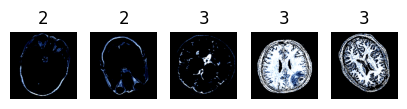

In [9]:
# Get a batch of images
images, labels = next(iter(dl_train))

# Use matplotlib to display images
fig, axes = plt.subplots(1, 5, figsize=(5, 5))

for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Reorder dimensions for visualization
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(labels[i].item())

plt.show()

# Train-Test Loop

In [ ]:
def train(model, dl, loss, optimizer, epoch, device='cpu'):
    model.to(device)
    model.train() #from nn.Module
    correct = 0
    train_loss = 0
    for data, target in dl:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data) #(batch_size,3,32,32) --> (10)
        batch_loss = loss(output, target) #(10x10) --> 1
        batch_loss.backward() #calculates gradients
        optimizer.step() #updates weights and kernels
        train_loss += batch_loss.detach().item()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    correct = 100. * correct / len(dl.dataset)
    train_loss /= len(dl)

    print(f'Epoch: {epoch}, Avarage train loss: {train_loss:.2f}, Accuracy: {correct:.1f}%')
    return train_loss, correct

In [ ]:
def test(model, dl_test, loss, device='cpu'):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no need to track gradients. Saves memory.
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = loss(output,target)
            test_loss += batch_loss.detach().item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    test_loss /= len(dl_test)
    correct = 100. * correct / len(dl_test.dataset)
    print(f'Avarage test loss: {test_loss:.2f}, Accuracy: {correct:.1f}%')
    return test_loss, correct

#Model ViT

In [10]:
pretrained_model = torchvision.models.vit_b_16('IMAGENET1K_V1')

pretrained_model.heads = nn.Sequential(
    nn.Linear(768, 4)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 135MB/s]


In [ ]:
#Run with A100-GPU
lr = 5e-5
momentum = 0.9
weight_decay = 5e-5
epochs = 25
save_model_path = '/content/gdrive/MyDrive/Colab Notebooks/MRI_for_brain_tumor/vit_model_augmented'
torch.manual_seed(4321) #fixes initial weights and kernels to test different models/hyperparameters

device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

params = [param for name, param in pretrained_model.named_parameters() if name not in ["heads.0.weight", "heads.0.bias"]] # all params except the last layer

optimizer = torch.optim.SGD([{'params': params}, {'params': pretrained_model.heads.parameters(), 'lr': 10 * lr}], lr=lr, momentum=momentum, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

loss = nn.CrossEntropyLoss()

# run()
a = time.time()
trainloss = []
testloss = []
trainacc = []
testacc = []
best_acc = 0

for epoch in range(0, epochs):
    train_loss, train_acc = train(pretrained_model, dl_train, loss, optimizer, epoch+1, device=device)
    trainloss.append(train_loss)
    trainacc.append(train_acc)
    test_loss, test_acc = test(pretrained_model, dl_test, loss, device=device)
    testloss.append(test_loss)
    testacc.append(test_acc)
    scheduler.step()
    if test_acc > best_acc:
      best_acc = test_acc
      best_train_acc = train_acc
      best_epoch = epoch
      torch.save(pretrained_model.state_dict(), save_model_path)
    else:
      if epoch - best_epoch > 3:
        break

b = time.time()
print(f'Training took {round(b - a, 0)} seconds.')

Epoch: 1, Avarage train loss: 0.65, Accuracy: 77.9%
Avarage test loss: 0.53, Accuracy: 81.3%
Epoch: 2, Avarage train loss: 0.34, Accuracy: 88.3%
Avarage test loss: 0.40, Accuracy: 85.0%
Epoch: 3, Avarage train loss: 0.27, Accuracy: 90.3%
Avarage test loss: 0.35, Accuracy: 85.8%
Epoch: 4, Avarage train loss: 0.23, Accuracy: 92.1%
Avarage test loss: 0.33, Accuracy: 87.2%
Epoch: 5, Avarage train loss: 0.20, Accuracy: 93.0%
Avarage test loss: 0.26, Accuracy: 90.1%
Epoch: 6, Avarage train loss: 0.18, Accuracy: 93.3%
Avarage test loss: 0.23, Accuracy: 91.6%
Epoch: 7, Avarage train loss: 0.16, Accuracy: 94.5%
Avarage test loss: 0.24, Accuracy: 91.4%
Epoch: 8, Avarage train loss: 0.15, Accuracy: 94.5%
Avarage test loss: 0.20, Accuracy: 92.2%
Epoch: 9, Avarage train loss: 0.13, Accuracy: 95.3%
Avarage test loss: 0.18, Accuracy: 93.0%
Epoch: 10, Avarage train loss: 0.12, Accuracy: 95.6%
Avarage test loss: 0.19, Accuracy: 93.1%
Epoch: 11, Avarage train loss: 0.11, Accuracy: 96.3%
Avarage test los

highest test accuracy: 96.72, highest train accuracy: 98.21


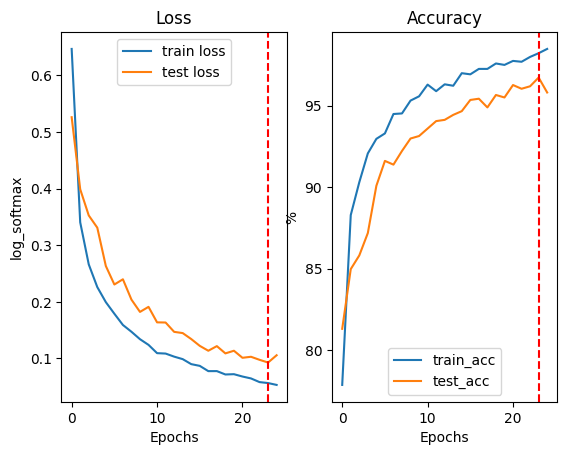

In [ ]:
print(f'highest test accuracy: {best_acc:.2f}, highest train accuracy: {best_train_acc:.2f}')
plt.subplot(1,2,1)
plt.plot(trainloss, label='train loss')
plt.plot(testloss, label='test loss')
plt.title('Loss')
plt.ylabel('log_softmax')
plt.xlabel('Epochs')
plt.axvline(x=best_epoch, color='r', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainacc, label='train_acc')
plt.plot(testacc,label='test_acc')
plt.title('Accuracy')
plt.ylabel('%')
plt.xlabel('Epochs')
plt.rcParams["figure.figsize"] = (15,6)
plt.axvline(x=best_epoch, color='r', linestyle='--')
plt.legend()
plt.show()

#Model ResNet

In [ ]:
pretrained_model2 = torchvision.models.resnet50('IMAGENET1K_V1')
pretrained_model2.fc = nn.Linear(pretrained_model2.fc.in_features, 4)
nn.init.xavier_uniform_(pretrained_model2.fc.weight);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [ ]:
#Run with A100-GPU
lr = 5e-5
momentum = 0.9
weight_decay = 5e-5
epochs = 25
save_model_path = '/content/gdrive/MyDrive/Colab Notebooks/MRI_for_brain_tumor/resnet_model_augmented'
torch.manual_seed(4321) #fixes initial weights and kernels to test different models/hyperparameters

device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

params = [param for name, param in pretrained_model2.named_parameters() if name not in ["fc.weight", "fc.bias"]] # all params except the last layer

optimizer = torch.optim.SGD([{'params': params}, {'params': pretrained_model2.fc.parameters(), 'lr': 10 * lr}], lr=lr, momentum=momentum, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

loss = nn.CrossEntropyLoss()

# run()
a = time.time()
trainloss = []
testloss = []
trainacc = []
testacc = []
best_acc = 0

for epoch in range(0, epochs):
    train_loss, train_acc = train(pretrained_model2, dl_train, optimizer, epoch+1, device=device)
    trainloss.append(train_loss)
    trainacc.append(train_acc)
    test_loss, test_acc = test(pretrained_model2, dl_test, device=device)
    testloss.append(test_loss)
    testacc.append(test_acc)
    scheduler.step()
    if test_acc > best_acc:
      best_acc = test_acc
      best_train_acc = train_acc
      best_epoch = epoch
      torch.save(pretrained_model2.state_dict(), save_model_path)
    else:
      if epoch - best_epoch > 3:
        break

b = time.time()
print(f'Training took {round(b - a, 0)} seconds.')

Epoch: 1, Avarage train loss: 0.84, Accuracy: 68.8%
Avarage test loss: 0.58, Accuracy: 79.7%
Epoch: 2, Avarage train loss: 0.46, Accuracy: 84.4%
Avarage test loss: 0.47, Accuracy: 82.5%
Epoch: 3, Avarage train loss: 0.37, Accuracy: 87.1%
Avarage test loss: 0.39, Accuracy: 85.0%
Epoch: 4, Avarage train loss: 0.31, Accuracy: 89.1%
Avarage test loss: 0.35, Accuracy: 86.1%
Epoch: 5, Avarage train loss: 0.29, Accuracy: 89.8%
Avarage test loss: 0.29, Accuracy: 89.1%
Epoch: 6, Avarage train loss: 0.24, Accuracy: 91.3%
Avarage test loss: 0.26, Accuracy: 90.6%
Epoch: 7, Avarage train loss: 0.22, Accuracy: 92.0%
Avarage test loss: 0.24, Accuracy: 91.7%
Epoch: 8, Avarage train loss: 0.21, Accuracy: 92.1%
Avarage test loss: 0.22, Accuracy: 91.0%
Epoch: 9, Avarage train loss: 0.19, Accuracy: 92.6%
Avarage test loss: 0.22, Accuracy: 92.2%
Epoch: 10, Avarage train loss: 0.19, Accuracy: 93.3%
Avarage test loss: 0.18, Accuracy: 93.3%
Epoch: 11, Avarage train loss: 0.17, Accuracy: 93.6%
Avarage test los

#Results

In [11]:
ds_train = BrainTumorDataset(root_dir=dataset_dir, transform=test_transforms)
ds_test = BrainTumorDataset(root_dir=dataset_dir_test, transform=test_transforms)

batch_size = 32
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

##ViT

In [12]:
pretrained_model = torchvision.models.vit_b_16('IMAGENET1K_V1')
pretrained_model.heads = nn.Sequential(
    nn.Linear(768, 4)
)
model_path = '/content/gdrive/MyDrive/Colab Notebooks/MRI_for_brain_tumor/vit_model_augmented'
pretrained_model.load_state_dict(torch.load(model_path,weights_only=True,map_location=torch.device('cpu')))
pretrained_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
device = 'cuda'
pretrained_model.to(device)
with torch.no_grad():
  pred_list_vit = []
  labels_list = []

  for images, labels in dl_train:
    images, labels = images.to(device), labels.to(device)
    preds_vit = pretrained_model(images.to(device))
    pred_list_vit.extend(preds_vit.argmax(dim=1, keepdim=True))
    labels_list.extend(labels.to(device))
  for images, labels in dl_test:
    images, labels = images.to(device), labels.to(device)
    preds_vit = pretrained_model(images.to(device))
    pred_list_vit.extend(preds_vit.argmax(dim=1, keepdim=True))
    labels_list.extend(labels.to(device))

In [ ]:
wrong_labels_index = []
wrongly_predicted_labels = []
ground_truth_labels = []

for i in range(len(pred_list_vit)):
  if pred_list_vit[i] != labels_list[i]:
    wrong_labels_index.append(i)
    wrongly_predicted_labels.append(pred_list_vit[i])
    ground_truth_labels.append(labels_list[i])

In [ ]:
len(wrong_labels_index)

131

In [ ]:
#Misclassification Analysis
confusion_matrix = np.zeros((4, 4), dtype=int)

# Populate the matrix
for gt, pred in zip(ground_truth_labels, wrongly_predicted_labels):
    confusion_matrix[gt, pred] += 1
df_confusion = pd.DataFrame(
    confusion_matrix,
    index=[f"Ground Truth {ds_train.classes[i]}" for i in range(4)],
    columns=[f"Predicted {ds_train.classes[j]}" for j in range(4)]
)
df_confusion

,Predicted meningioma,Predicted glioma,Predicted notumor,Predicted pituitary
Ground Truth meningioma,0,18,14,8
Ground Truth glioma,55,0,4,3
Ground Truth notumor,6,0,0,2
Ground Truth pituitary,16,0,5,0


ViT model performs well overall and avoids critical errors. However, one notable pattern in misclassification is the confusion between meningioma and glioma.

##ResNet

In [ ]:
pretrained_model2 = torchvision.models.resnet50('IMAGENET1K_V1')
pretrained_model2.fc = nn.Linear(pretrained_model2.fc.in_features, 4)
nn.init.xavier_uniform_(pretrained_model2.fc.weight);
model_path = '/content/gdrive/MyDrive/Colab Notebooks/MRI_for_brain_tumor/resnet_model_augmented'
pretrained_model2.load_state_dict(torch.load(model_path,weights_only=True,map_location=torch.device('cuda')))
pretrained_model2.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = 'cuda'
pretrained_model2.to(device)
with torch.no_grad():
  pred_list_resnet = []
  labels_list = []

  for images, labels in dl_train:
    images, labels = images.to(device), labels.to(device)
    preds_resnet = pretrained_model2(images.to(device))
    pred_list_resnet.extend(preds_resnet.argmax(dim=1, keepdim=True))
    labels_list.extend(labels.to(device))
  for images, labels in dl_test:
    images, labels = images.to(device), labels.to(device)
    preds_vit = pretrained_model(images.to(device))
    pred_list_vit.extend(preds_vit.argmax(dim=1, keepdim=True))
    labels_list.extend(labels.to(device))

In [ ]:
wrong_labels_index = []
wrongly_predicted_labels = []
ground_truth_labels = []

for i in range(len(pred_list_resnet)):
  if pred_list_resnet[i] != labels_list[i]:
    wrong_labels_index.append(i)
    wrongly_predicted_labels.append(pred_list_resnet[i])
    ground_truth_labels.append(labels_list[i])

In [ ]:
len(wrong_labels_index)

198

In [ ]:
#Misclassification Analysis
confusion_matrix = np.zeros((4, 4), dtype=int)

# Populate the matrix
for gt, pred in zip(ground_truth_labels, wrongly_predicted_labels):
    confusion_matrix[gt, pred] += 1
df_confusion = pd.DataFrame(
    confusion_matrix,
    index=[f"Ground Truth {ds_train.classes[i]}" for i in range(4)],
    columns=[f"Predicted {ds_train.classes[j]}" for j in range(4)]
)
df_confusion

,Predicted meningioma,Predicted glioma,Predicted notumor,Predicted pituitary
Ground Truth meningioma,0,35,30,28
Ground Truth glioma,47,0,1,2
Ground Truth notumor,4,4,0,1
Ground Truth pituitary,25,3,18,0
